In [20]:
import os
import numpy as np
import time
import scipy.stats as stats
from scipy.special import factorial
import csv
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.multitest as sm
from fisher import pvalue_npy
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score
from mpl_toolkits import mplot3d

In [21]:
df1 = pd.read_csv('./ocRMA/exp.mRNA.AgilentG4502A_07_2.txt',sep = "\t", index_col=0,header = 0)
df2 = pd.read_csv('./ocRMA/exp.mRNA.HT_HG-U133A.txt',sep = "\t", index_col=0,header = 0)
df3 = pd.read_csv('./ocRMA/exp.mRNA.GSE6008.RMA.txt',sep = "\t", index_col=0,header = 0)
df4 = pd.read_csv('./ocRMA/exp.mRNA.GSE18520.RMA.txt',sep = "\t", index_col=0,header = 0)
df5 = pd.read_csv('./ocRMA/exp.mRNA.GSE40595.RMA.txt',sep = "\t", index_col=0,header = 0)
df6 = pd.read_csv('./ocRMA/mRNA.validation.txt',sep = "\t", index_col=0,header = 0)
df6 = df6.drop(df6.columns[range(8,16)],axis=1)

print(df1.shape)
print(df2.shape)
print (df3.shape)
print (df4.shape)
print (df5.shape)
print (df6.shape)

(17814, 37)
(12042, 593)
(12548, 45)
(21655, 63)
(21655, 38)
(17995, 16)


In [22]:
df1.dropna(axis=0, inplace=True)
print(df1.shape)

(17799, 37)


In [23]:
comidx = df1.index.join(
    df2.index.join(
        df3.index.join(
            df4.index.join(
                df5.index.join(
                    df6.index,how='inner')
            ,how='inner')
        ,how='inner')
    ,how='inner')
,how='inner')

In [24]:
df1 = df1.loc[comidx]
df2 = df2.loc[comidx]
df3 = df3.loc[comidx]
df4 = df4.loc[comidx]
df5 = df5.loc[comidx]
df6 = df6.loc[comidx]
    
print(df1.shape)
print(df2.shape)
print (df3.shape)
print (df4.shape)
print (df5.shape)
print (df6.shape)

(9510, 37)
(9510, 593)
(9510, 45)
(9510, 63)
(9510, 38)
(9510, 16)


In [25]:
lab1 = np.genfromtxt('./oclabel/AgilentG4502A_07_2.label.txt',dtype="U16,u1")['f1']
lab2 = np.genfromtxt('./oclabel/HT_HG-U133A.label.txt',dtype="U16,u1")['f1']
lab3 = np.genfromtxt('./oclabel/GSE6008.label.txt',dtype="U16,U16,u1")['f2']
lab4 = np.genfromtxt('./oclabel/GSE18520.label.txt',dtype="U16,U16,U16,u1,u1")['f4']
lab5 = np.genfromtxt('./oclabel/GSE40595.label.txt',dtype="U16,U16,U16,U16,U16,U16,U16,u1")['f7']
lab6 = np.genfromtxt('./oclabel/mRNA.label.txt',dtype="U16,u1")['f1']
lab6 = np.delete(lab6,range(8,16))

In [26]:
x_train = np.concatenate((df2.to_numpy(),df4.to_numpy(),df6.to_numpy()),axis=1).T
y_train = np.concatenate((lab2,lab4,lab6))
x_train1 = df2.to_numpy().T
y_train1 = lab2
x_train2 = df4.to_numpy().T
y_train2 = lab4

x_test1 = df3.to_numpy().T
x_test2 = df5.to_numpy().T
x_test3 = df1.to_numpy().T
x_test4 = df6.to_numpy().T
y_test1 = lab3
y_test2 = lab5
y_test3 = lab1
y_test4 = lab6

length = len(x_train[0,:])
n_sm = len(x_train[:,0])
print ("Shape of training data: ",x_train.shape)
print ("length of data = ", length)
print ("number of samples = ", n_sm)

Shape of training data:  (672, 9510)
length of data =  9510
number of samples =  672


TCGA
GSE18520
Ours
test1GEO
test2GEO
test3TCGA


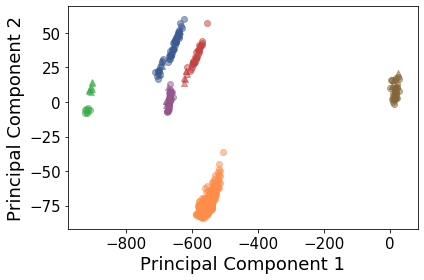

In [65]:
from mlxtend.feature_extraction import PrincipalComponentAnalysis

pca = PrincipalComponentAnalysis(n_components=2)
pca.fit(np.concatenate((x_train1,x_train2,x_test4,x_test1,x_test2,x_test3)))

colors = [sns.xkcd_rgb['orangeish'],sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['medium green'],
         sns.xkcd_rgb['purplish'],sns.xkcd_rgb['reddish'],sns.xkcd_rgb['dirt brown']]
x_test = [x_train1,x_train2,x_test4,x_test1,x_test2,x_test3]
y_test = [y_train1,y_train2,y_test4,y_test1,y_test2,y_test3]
testname = ["TCGA","GSE18520","Ours","test1GEO","test2GEO","test3TCGA"]



plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)
# plt.figure(figsize=(6, 4))
plt.figure()
legs = ['control','case']

for X,y,ds,col in zip(x_test,y_test,testname,colors):
    X_pca = pca.transform(X)

    for lab, mak,leg in zip((0, 1),('^', 'o'),legs):
        plt.scatter(X_pca[y==lab, 0],
                    X_pca[y==lab, 1],
                    label=ds,
                    marker=mak,
                    c=col,
                   alpha = 1/2)
    print(ds)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)
# plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.tight_layout()
plt.savefig('PCA.png',dpi=600)
plt.show()

In [53]:
dfcom = pd.read_csv('./ocRMA/ov.combat.txt',sep = "\t", index_col=0,header = 0)
dfcom.dropna(axis=0, inplace=True)
print(dfcom.shape)
labcom = np.genfromtxt('./oclabel/ov.allabel.txt',dtype="u1,U16,u1,u1")['f3']

(9510, 792)


In [54]:
# imulabel = pd.read_csv('./oclabel/immport.mRNA0728.txt').values
# imulabel = np.squeeze(imulabel)
# imuidx = pd.Index(imulabel)
# comidx = df1.index.join(
#     df2.index.join(
#         df3.index.join(
#             df4.index.join(
#                 df5.index.join(
#                     df6.index.join(imuidx,how='inner'),how='inner')
#             ,how='inner')
#         ,how='inner')
#     ,how='inner')
# ,how='inner')
# dfcom = dfcom.loc[comidx]

In [55]:
X_test3 = dfcom.iloc[:,0:37].to_numpy().T
X_train2 = dfcom.iloc[:,37:100].to_numpy().T
X_test2 = dfcom.iloc[:,100:138].to_numpy().T
X_test1 = dfcom.iloc[:,138:183].to_numpy().T
X_train1 = dfcom.iloc[:,183:776].to_numpy().T
X_test4 = dfcom.iloc[:,776:].to_numpy().T

Y_test3 = labcom[0:37]
Y_train2 = labcom[37:100]
Y_test2 = labcom[100:138]
Y_test1 = labcom[138:183]
Y_train1 = labcom[183:776]
Y_test4 = labcom[776:]

TCGA
GSE18520
Ours
test1GEO
test2GEO
test3TCGA


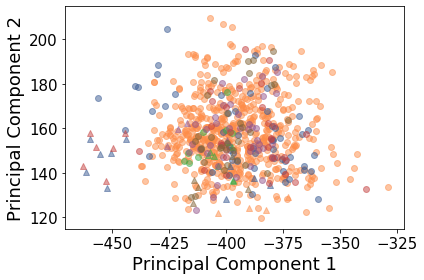

In [67]:
pca = PrincipalComponentAnalysis(n_components=2)
pca.fit(dfcom.to_numpy().T)

colors = [sns.xkcd_rgb['orangeish'],sns.xkcd_rgb['denim blue'],sns.xkcd_rgb['medium green'],
         sns.xkcd_rgb['purplish'],sns.xkcd_rgb['reddish'],sns.xkcd_rgb['dirt brown']]
x_test = [X_train1,X_train2,X_test4,X_test1,X_test2,X_test3]
y_test = [Y_train1,Y_train2,Y_test4,Y_test1,Y_test2,Y_test3]
testname = ["TCGA","GSE18520","Ours","test1GEO","test2GEO","test3TCGA"]

# x_test = [X_train2,X_test2]
# y_test = [Y_train2,Y_test2]
# testname = ["GSE18520","test2GEO"]

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.figure(figsize=(6, 4))
plt.figure()
legs = ['control','case']

for X,y,ds,col in zip(x_test,y_test,testname,colors):
    X_pca = pca.transform(X)

    for lab, mak,leg in zip((0, 1),('^', 'o'),legs):
        plt.scatter(X_pca[y==lab, 0],
                    X_pca[y==lab, 1],
                    label=ds,
                    marker=mak,
                    c=col,
                   alpha = 1/2)
    print(ds)
plt.xlabel('Principal Component 1', fontsize=18)
plt.ylabel('Principal Component 2', fontsize=18)
# plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.tight_layout()
plt.savefig('PCAcombat.png',dpi=600)
plt.show()

Accent


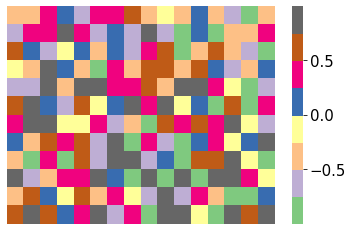

Accent_r


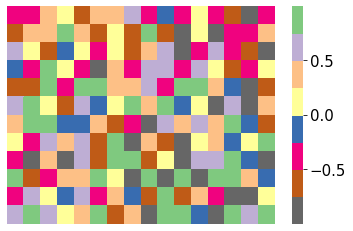

Blues


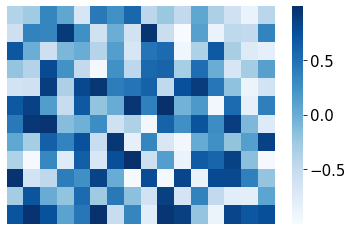

Blues_r


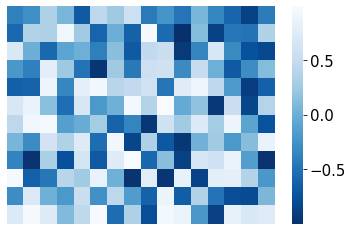

BrBG


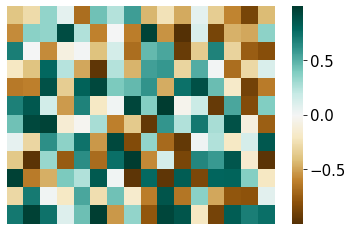

BrBG_r


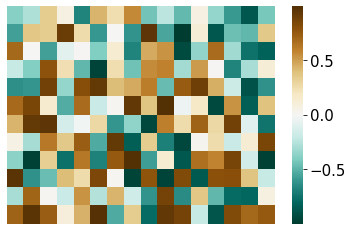

BuGn


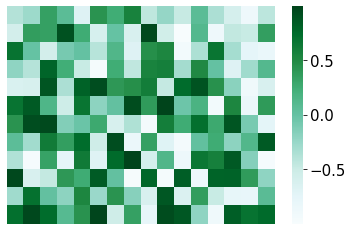

BuGn_r


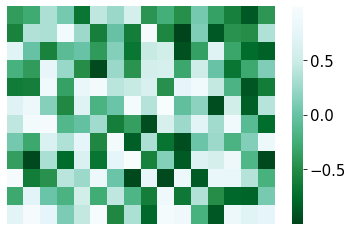

BuPu


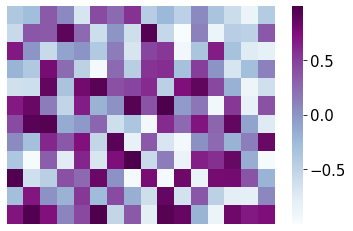

BuPu_r


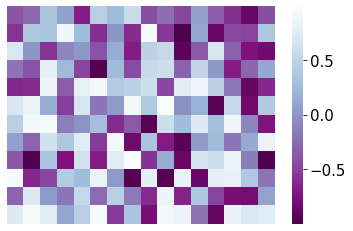

CMRmap


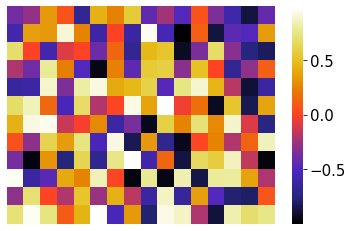

CMRmap_r


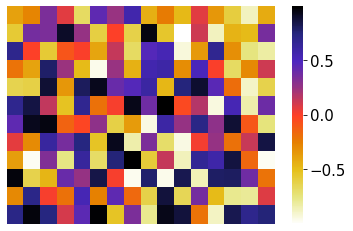

Dark2


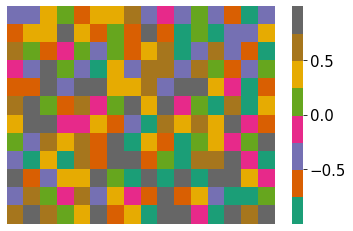

Dark2_r


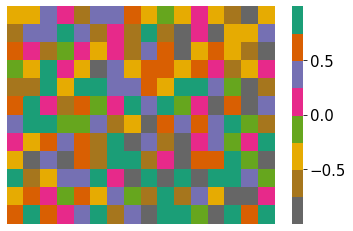

GnBu


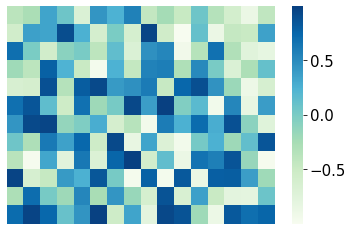

GnBu_r


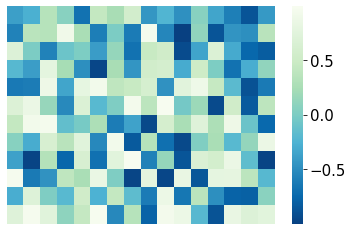

Greens


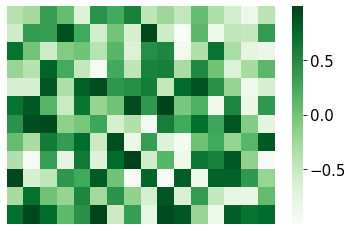

Greens_r


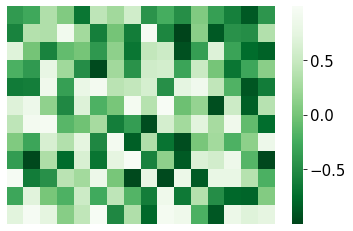

Greys


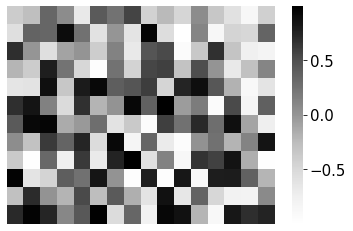

Greys_r


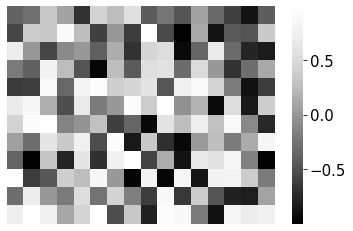

OrRd


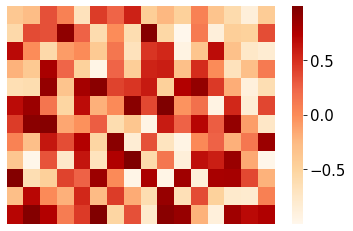

OrRd_r


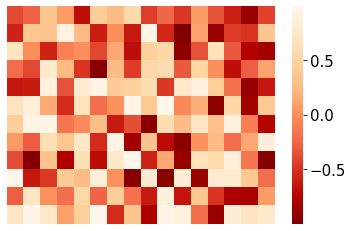

Oranges


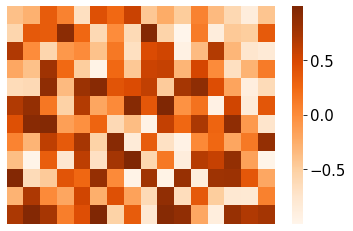

Oranges_r


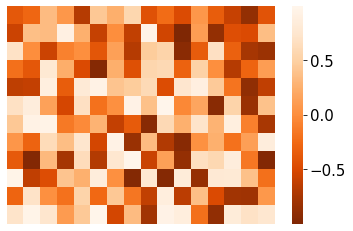

PRGn


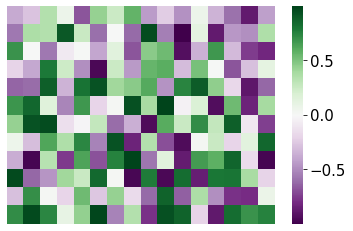

PRGn_r


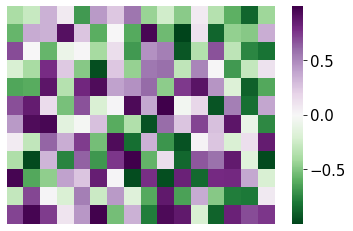

Paired


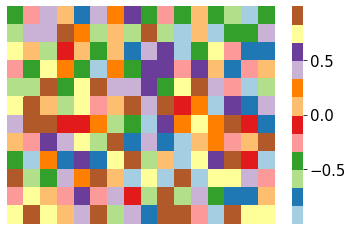

Paired_r


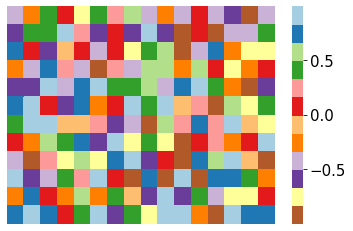

Pastel1


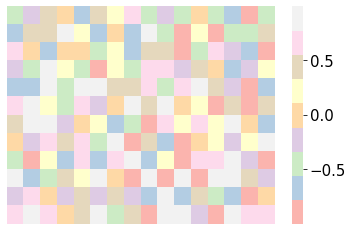

Pastel1_r


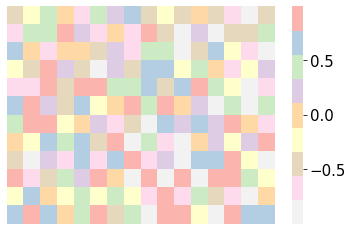

Pastel2


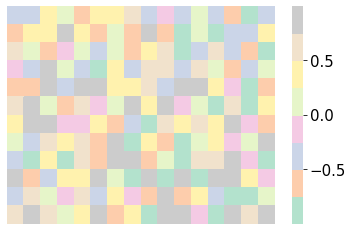

Pastel2_r


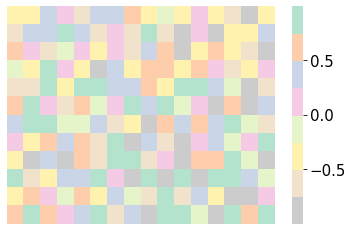

PiYG


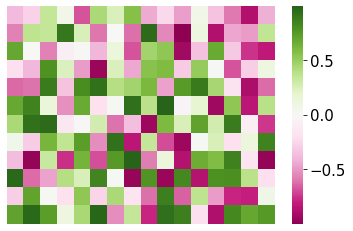

PiYG_r


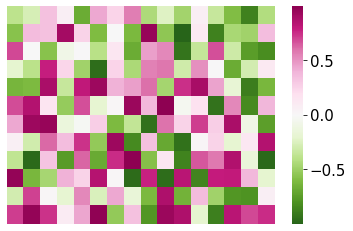

PuBu


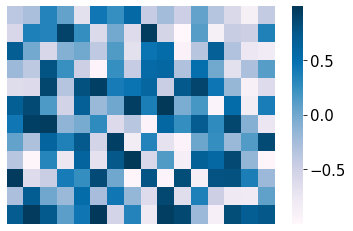

PuBuGn


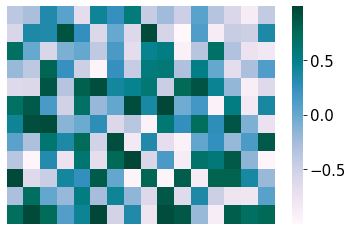

PuBuGn_r


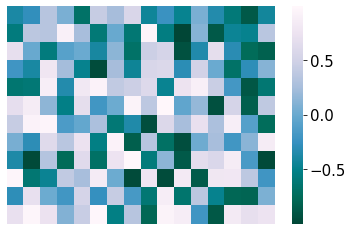

PuBu_r


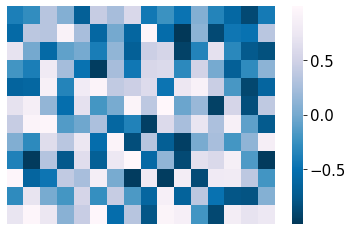

PuOr


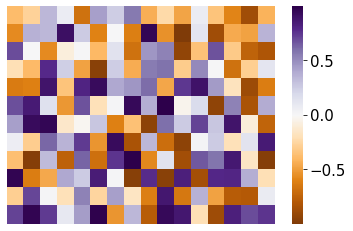

PuOr_r


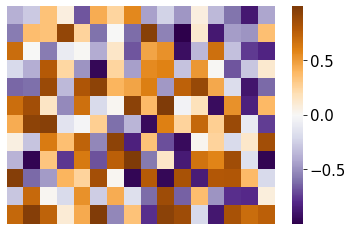

PuRd


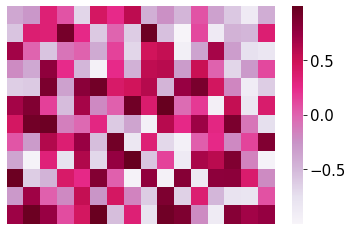

PuRd_r


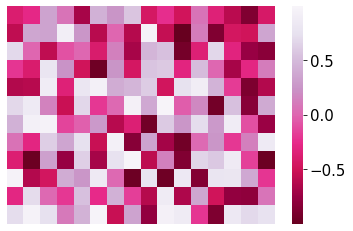

Purples


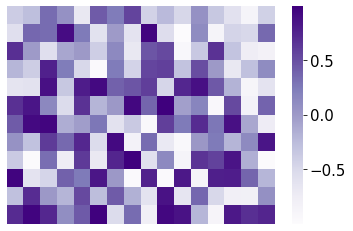

Purples_r


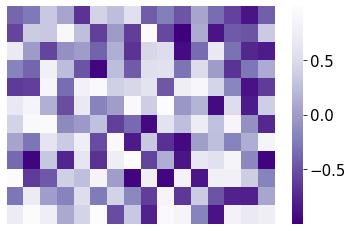

RdBu


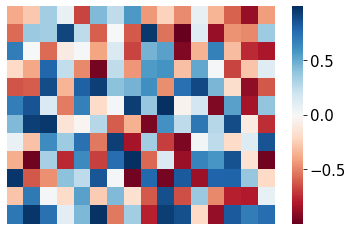

RdBu_r


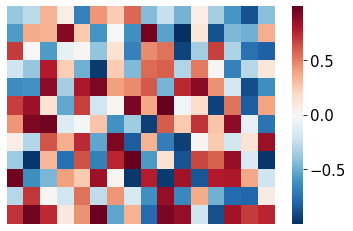

RdGy


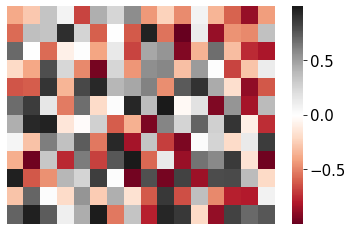

RdGy_r


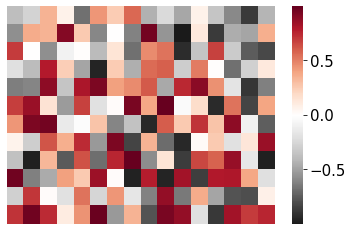

RdPu


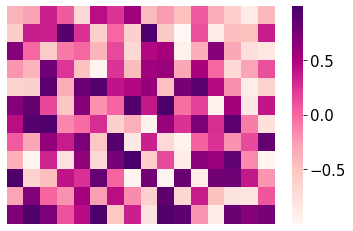

RdPu_r


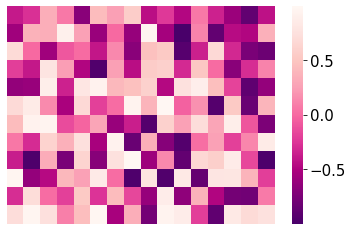

RdYlBu


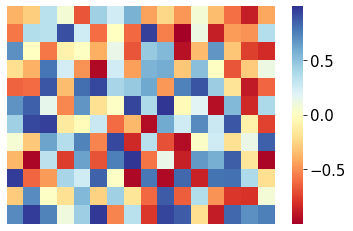

RdYlBu_r


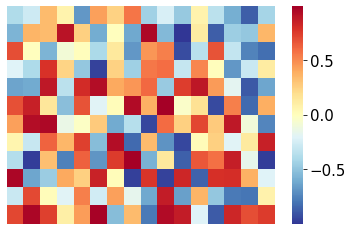

RdYlGn


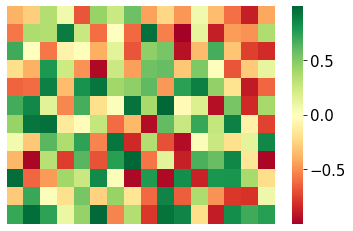

RdYlGn_r


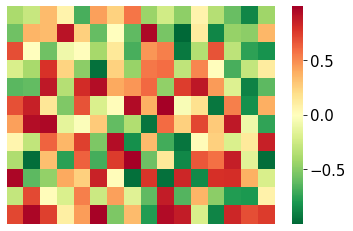

Reds


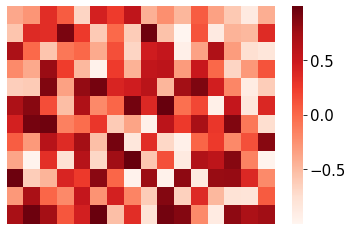

Reds_r


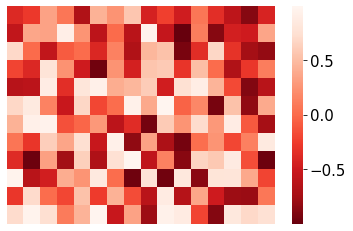

Set1


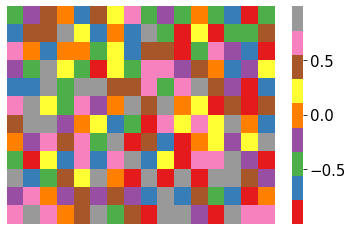

Set1_r


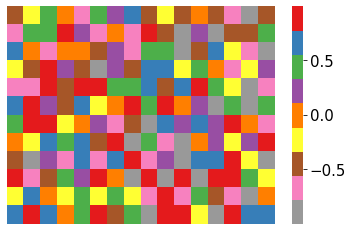

Set2


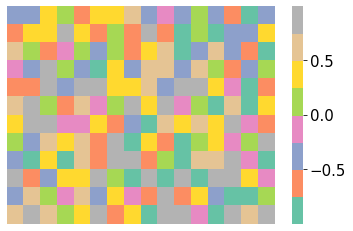

Set2_r


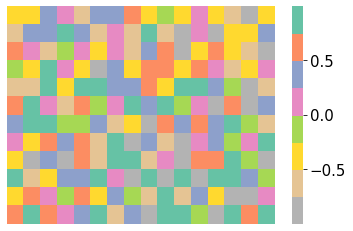

Set3


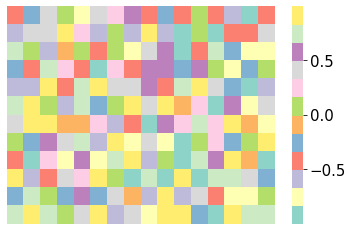

Set3_r


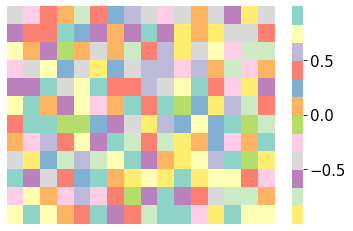

Spectral


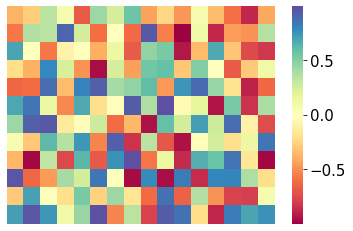

Spectral_r


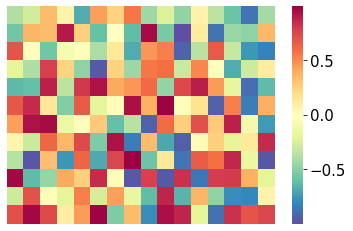

Wistia


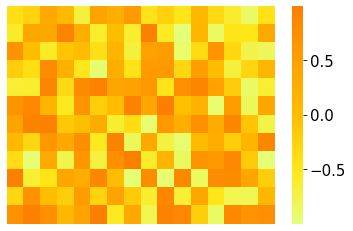

Wistia_r


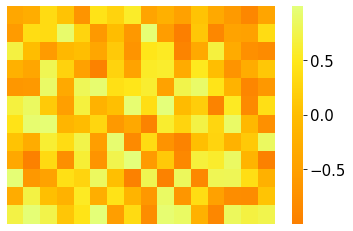

YlGn


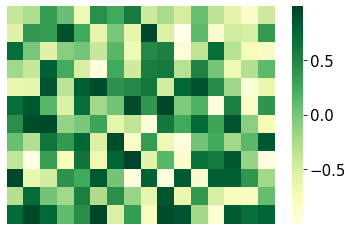

YlGnBu


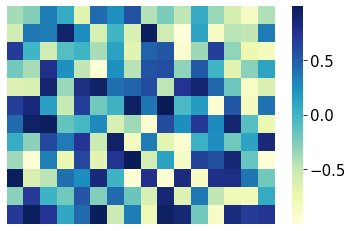

YlGnBu_r


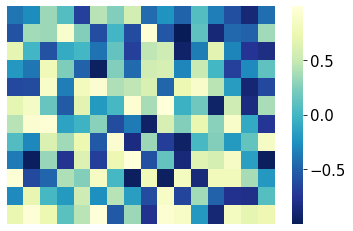

YlGn_r


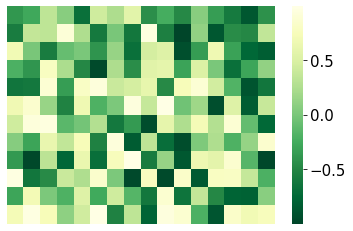

YlOrBr


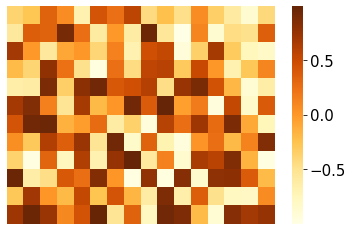

YlOrBr_r


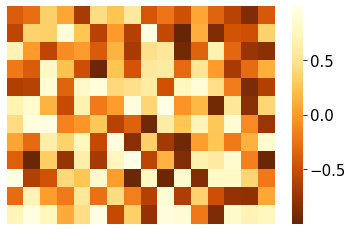

YlOrRd


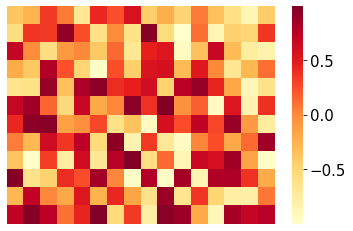

YlOrRd_r


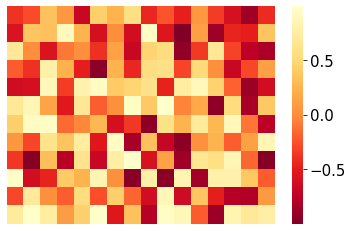

afmhot


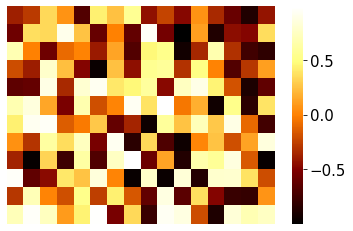

afmhot_r


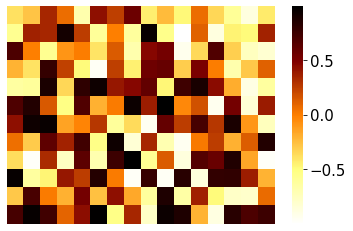

autumn


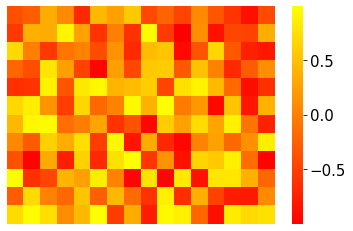

autumn_r


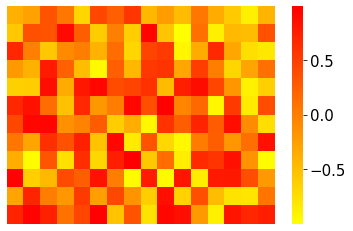

binary


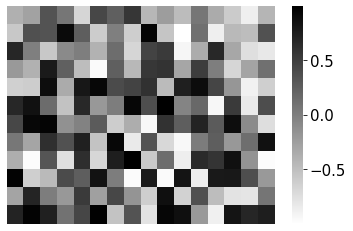

binary_r


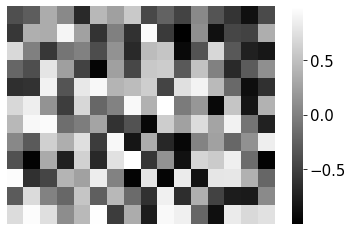

bone


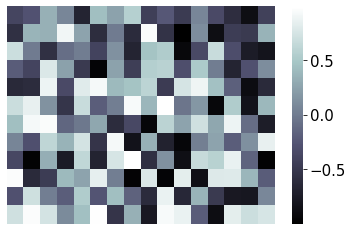

bone_r


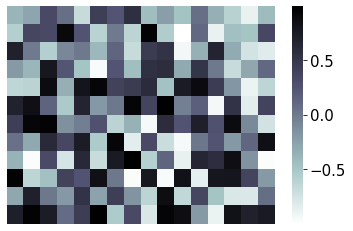

brg


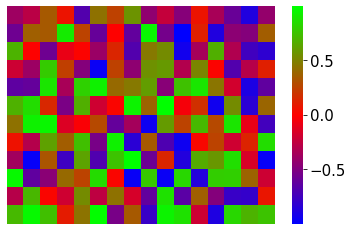

brg_r


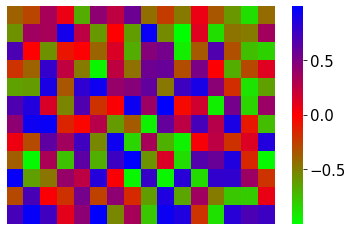

bwr


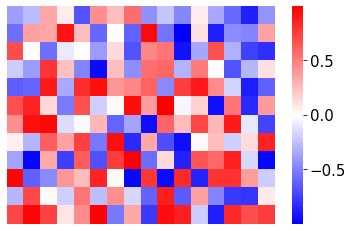

bwr_r


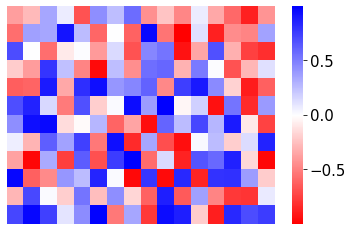

cividis


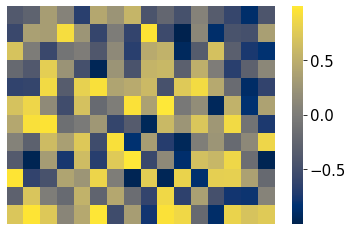

cividis_r


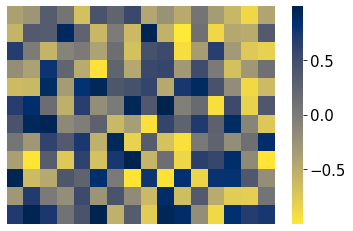

cool


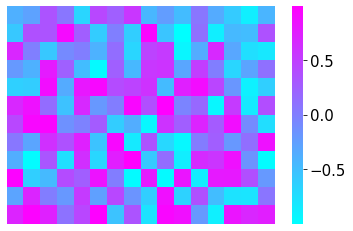

cool_r


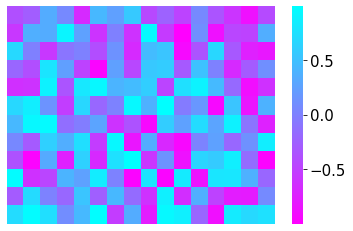

coolwarm


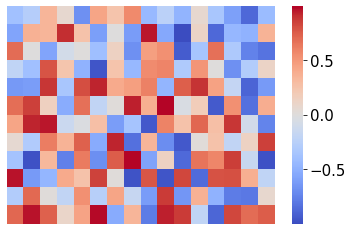

coolwarm_r


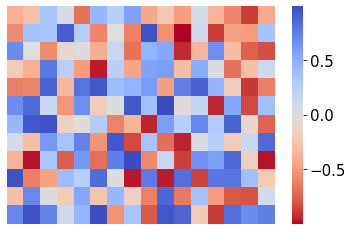

copper


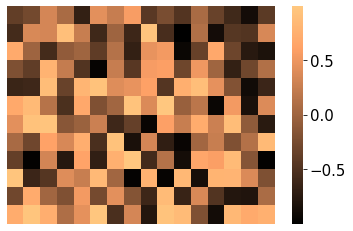

copper_r


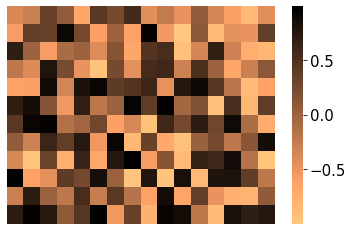

cubehelix


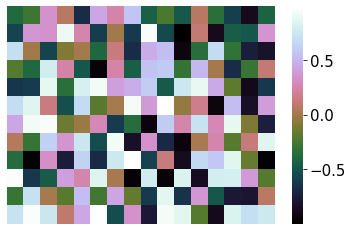

cubehelix_r


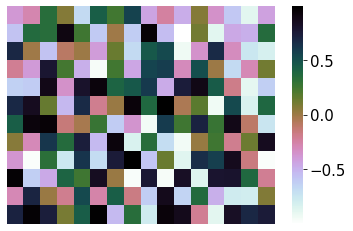

flag


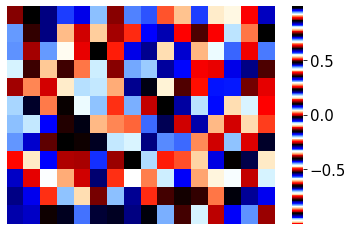

flag_r


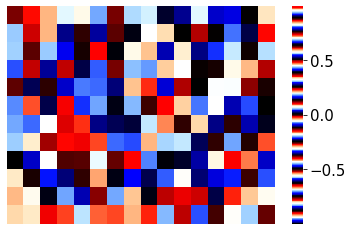

gist_earth


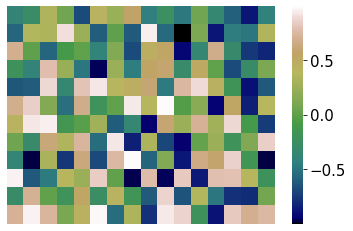

gist_earth_r


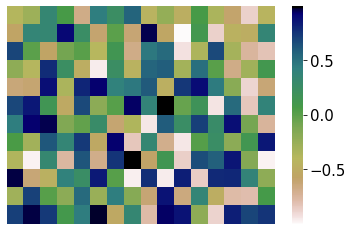

gist_gray


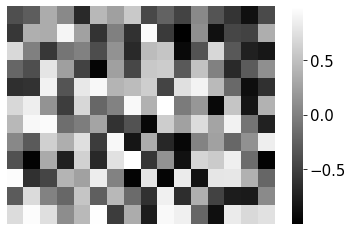

gist_gray_r


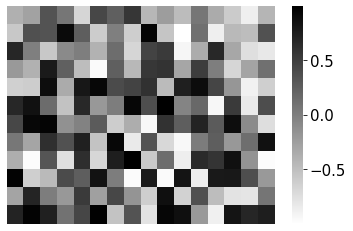

gist_heat


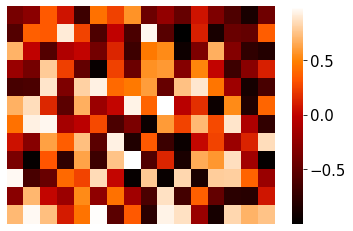

gist_heat_r


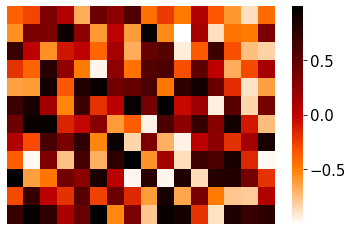

gist_ncar


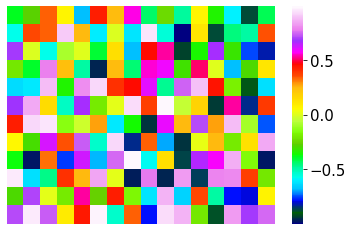

gist_ncar_r


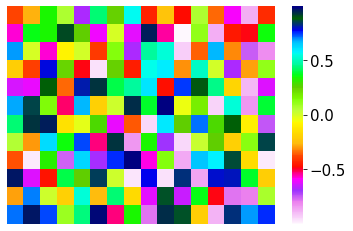

gist_rainbow


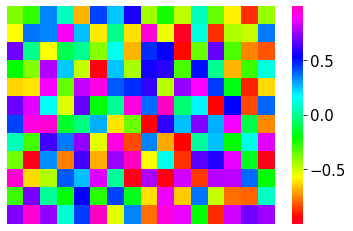

gist_rainbow_r


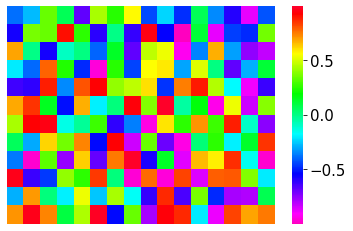

gist_stern


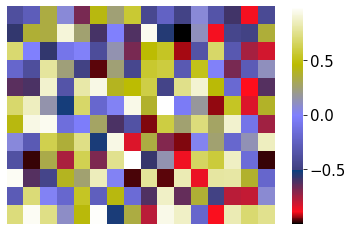

gist_stern_r


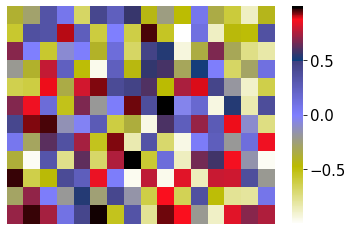

gist_yarg


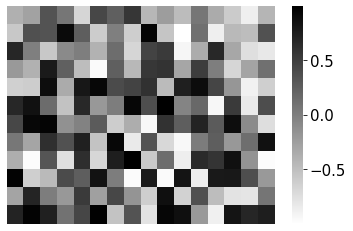

gist_yarg_r


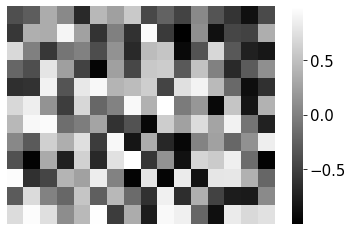

gnuplot


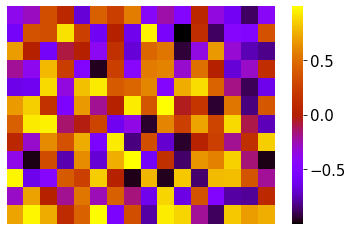

gnuplot2


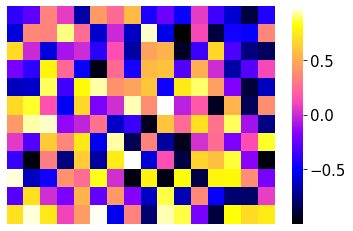

gnuplot2_r


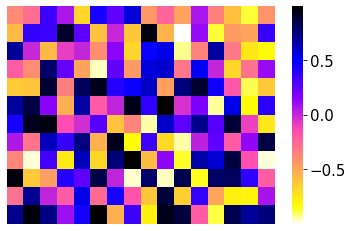

gnuplot_r


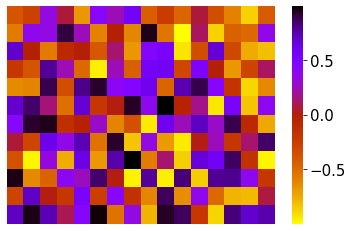

gray


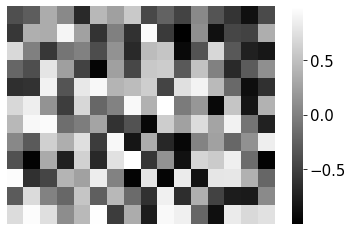

gray_r


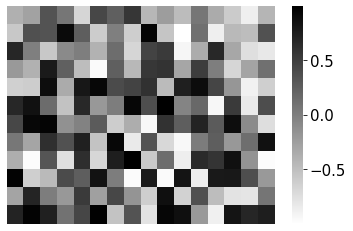

hot


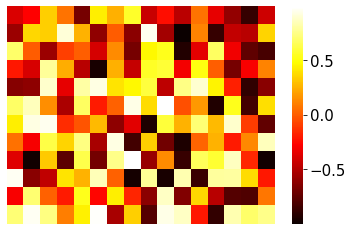

hot_r


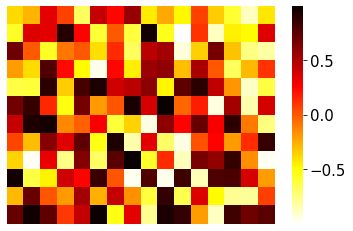

hsv


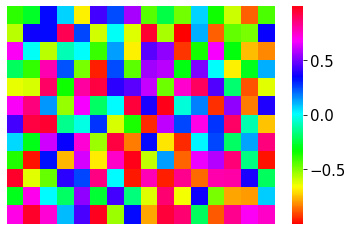

hsv_r


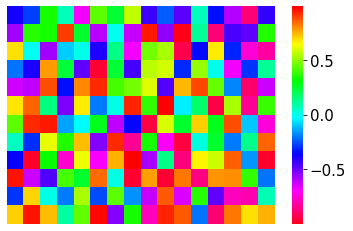

icefire


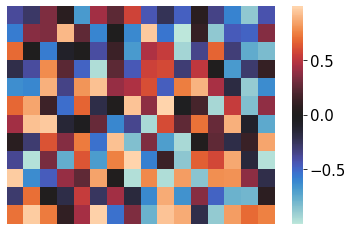

icefire_r


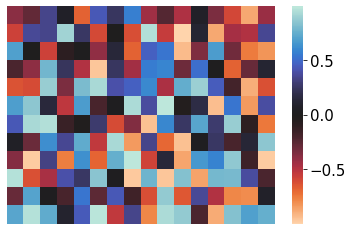

inferno


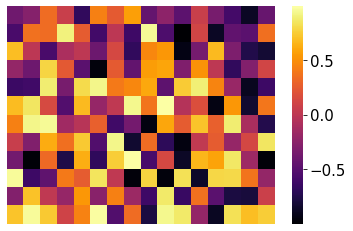

inferno_r


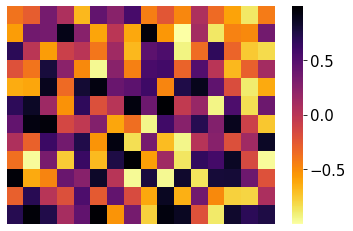

jet


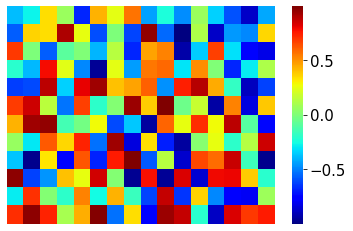

jet_r


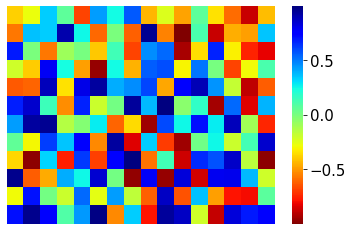

magma


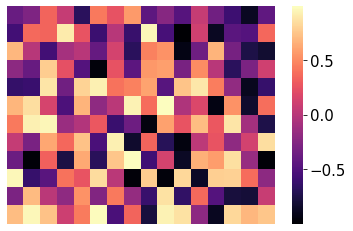

magma_r


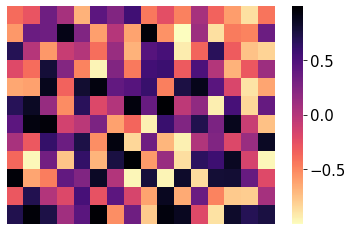

mako


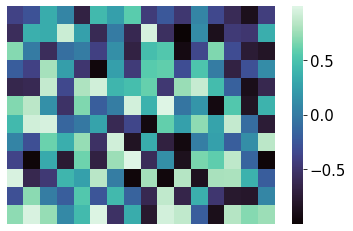

mako_r


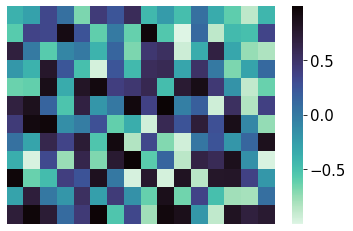

nipy_spectral


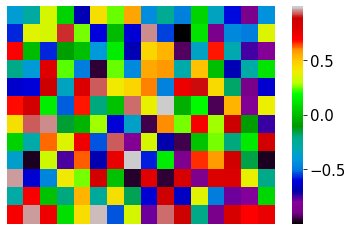

nipy_spectral_r


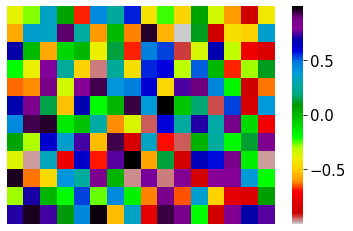

ocean


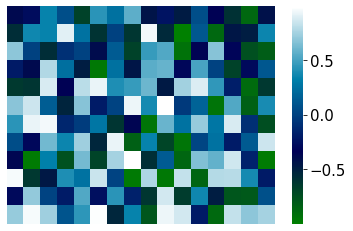

ocean_r


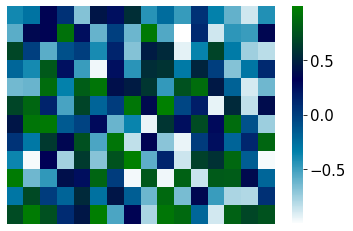

pink


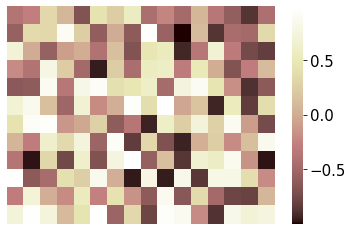

pink_r


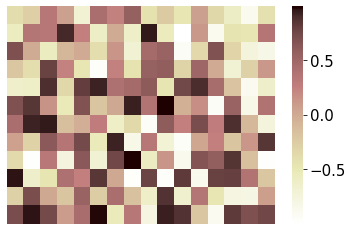

plasma


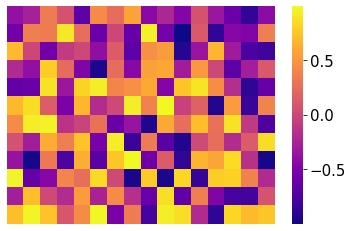

plasma_r


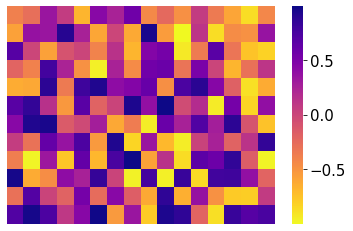

prism


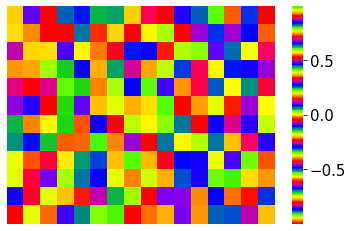

prism_r


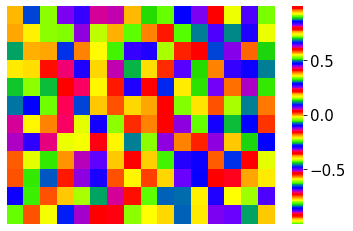

rainbow


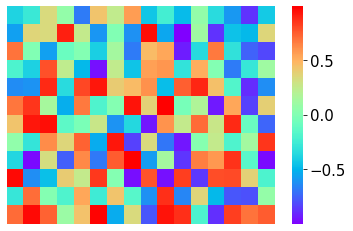

rainbow_r


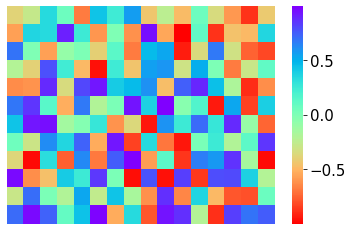

rocket


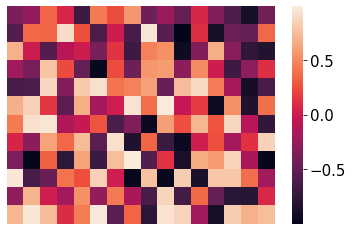

rocket_r


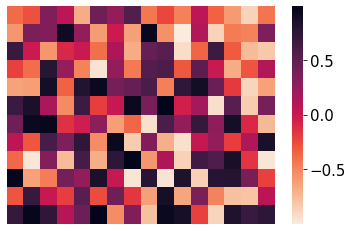

seismic


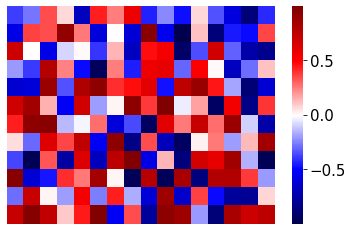

seismic_r


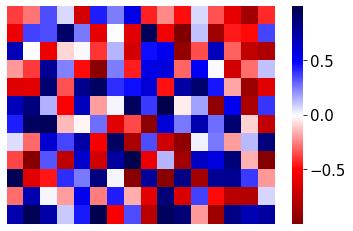

spring


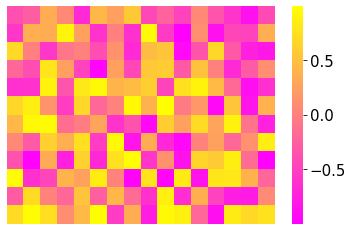

spring_r


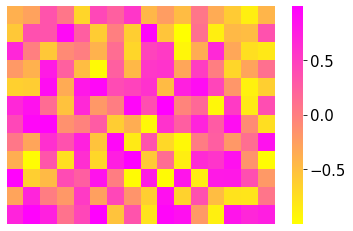

summer


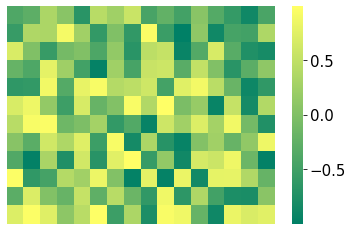

summer_r


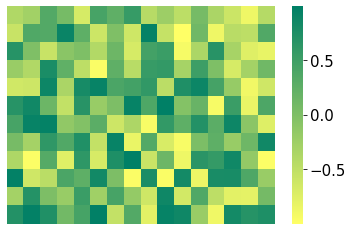

tab10


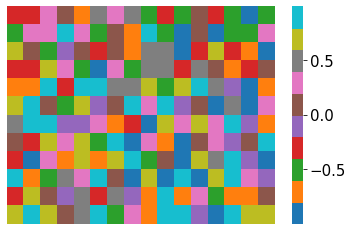

tab10_r


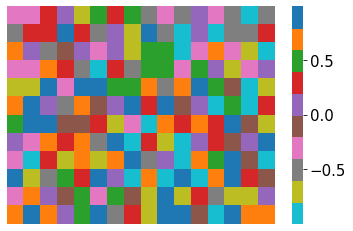

tab20


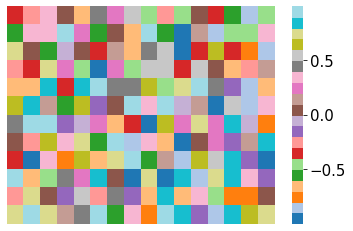

tab20_r


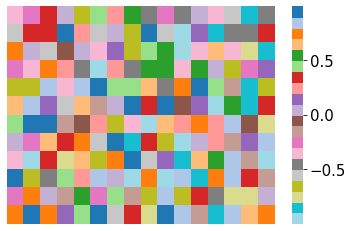

tab20b


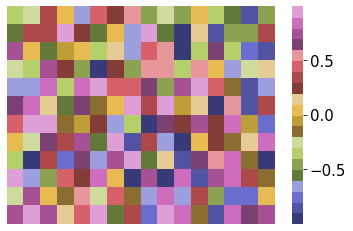

tab20b_r


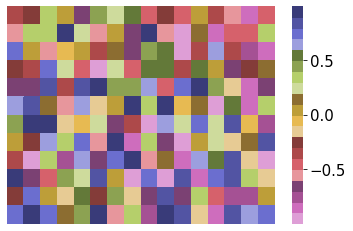

tab20c


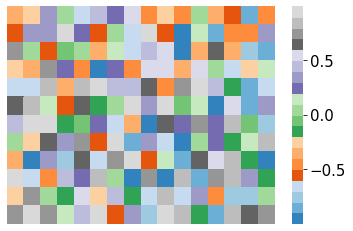

tab20c_r


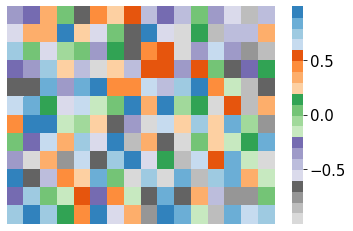

terrain


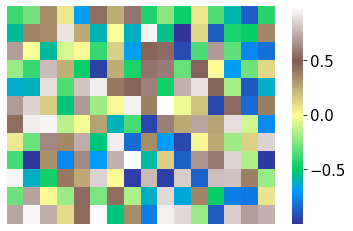

terrain_r


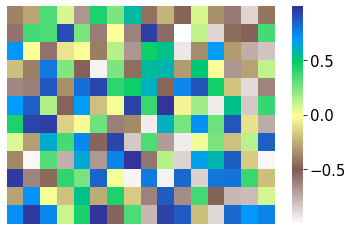

twilight


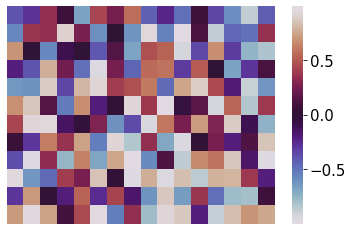

twilight_r


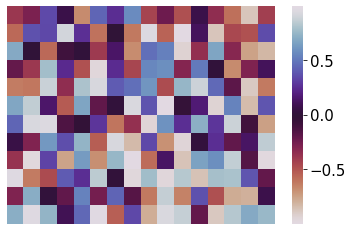

twilight_shifted


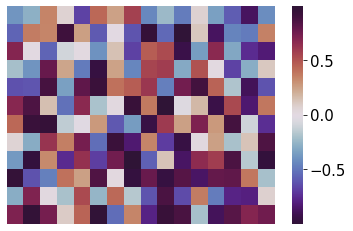

twilight_shifted_r


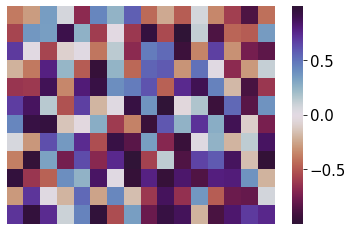

viridis


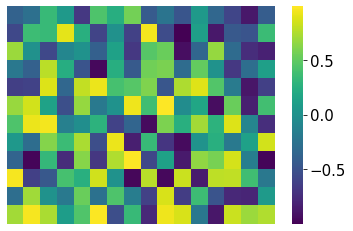

viridis_r


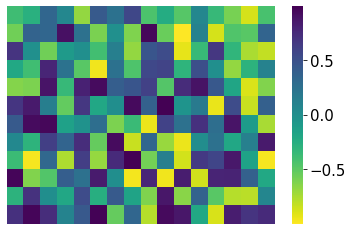

vlag


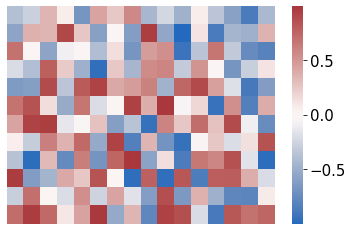

vlag_r


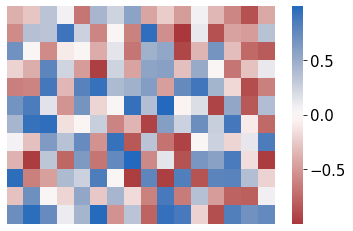

winter


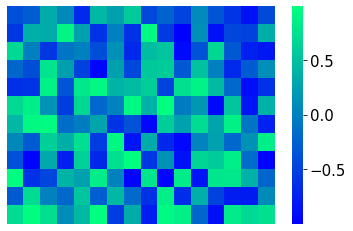

winter_r


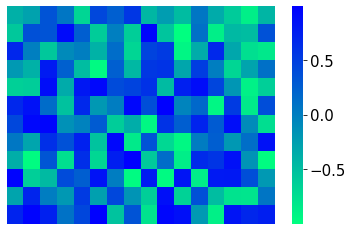

In [145]:
colors = []
str1 = "Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG"
str2 = "PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r"
str3 = "YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r"
str4 = "gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako"
str5 = "mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r"
str6 = "twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r"
for st in [str1,str2,str3,str4,str5,str6]:
    colors.extend(st.split(', '))

uniform_data = np.random.rand(12, 16)*2-1
uniform_data = np.random.rand(12, 16)*2-1
for c in colors:
    print(c)
    ax = sns.heatmap(uniform_data,xticklabels = False, yticklabels = False, cmap = c)
    plt.show()
#     plt.savefig('./workflow/heatmap.png',dpi=600)

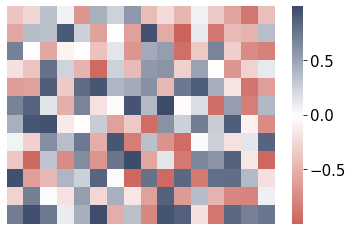

In [208]:
ax = sns.heatmap(uniform_data,xticklabels = False, yticklabels = False, cmap = custom_ramp)
plt.savefig('./workflow/heatmap.svg',dpi=600)

In [72]:
df6 = pd.read_csv('./ocRMA/mRNA.validation.txt',sep = "\t", index_col=0,header = 0)
df6 = df6.drop(df6.columns[range(8,16)],axis=1)
lab6 = np.genfromtxt('./oclabel/mRNA.label.txt',dtype="U16,u1")['f1']
lab6 = np.delete(lab6,range(8,16))

In [ ]:
x_train = df6.to_numpy().T
y_train = lab6

diff = 0
length = len(x_train[0,:])
n_sm = len(x_train[:,0])
result1 = np.zeros([length,length,n_sm],dtype=np.bool)
result1_ = np.zeros([length,length,n_sm],dtype=np.bool)
for i in range(0,n_sm):
    time_l = time.time()
    x = np.tile(x_train[i,:], (length,1))
    sub = x - x.T
    
    result1[:,:,i] = (sub > diff)
    result1_[:,:,i] = (sub < -diff)
    
con_label = 1 - y_train
a = np.sum(result1 * con_label, axis = 2)
b = np.sum(result1_* con_label, axis = 2)

# Case
c = np.sum(result1 * y_train, axis = 2)
d = np.sum(result1_* y_train, axis = 2)

In [ ]:
rev_list = [1]

num_disease = np.sum(y_train)
num_control = len(y_train) - num_disease

print ("num of case: ", num_disease)
print ("num of control: ", num_control)

for rev in rev_list:
    at = ((a.astype(float)/num_control) >= rev)
    dt = ((d.astype(float)/num_disease) >= rev)

    index0, index1 = np.where(at * dt>0)
    
    for i in range(0,len(index0)):
        if index0[i] > index1[i]:
            index0[i],index1[i] = index1[i],index0[i]   
    print ("reversal percentage = ", rev)
    print ("number of pairs = ", len(index0))
    print ("number of genes = ", len(np.union1d(index0,index1)))
    
index = np.stack((index0, index1))

index_ = index.T
print("a ,b ,c ,d ")
for i,j in index_ :
    print(a[i,j], b[i,j], c[i,j], d[i,j])

In [79]:
index.shape

(2, 1291129)

In [97]:
idx = index[:,0:10]
idx

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  89,  200,  472,  742,  889,  929,  933, 1008, 1020, 1199]])

In [87]:
x_train[:,np.union1d(idx[0],idx[1])]

array([[ 5.8215,  8.1332,  9.2042,  8.2483,  9.724 ,  8.6   , 10.9688,
         9.213 ,  8.2314,  9.4211,  8.5636],
       [ 6.6528,  8.5291,  8.8427,  8.5237,  8.0991,  8.8013, 13.1439,
         9.095 ,  8.1986,  9.0156,  8.1212],
       [ 5.6347,  8.0555,  8.8657,  7.8914,  7.3476,  9.8149, 10.7183,
         9.5506,  9.0978,  8.17  ,  7.7303],
       [ 5.4855,  8.3873,  9.0107,  7.6055,  8.9582,  8.9155, 12.2509,
         9.2218,  7.6798,  9.3957,  8.0466],
       [ 5.2549,  7.6651,  8.7152,  7.6354,  8.5573,  8.4631, 11.0206,
        10.1415,  8.6232,  9.0799,  7.7736],
       [ 5.3641,  7.7315,  8.7622,  7.7741,  8.5516,  8.3206, 10.9922,
        10.1064,  8.5878,  9.1093,  7.7542],
       [ 5.9396,  7.805 ,  8.8317,  7.8234,  7.2999,  9.7571, 10.6617,
         9.614 ,  8.9712,  8.1648,  7.6924],
       [ 5.4622,  8.4117,  9.0097,  7.7551,  8.9973,  8.8322, 12.1626,
         9.2037,  7.6508,  9.3481,  8.1024],
       [ 7.4319,  5.0877,  5.1121,  5.4177,  4.4166,  5.5471,  3.7061,
 

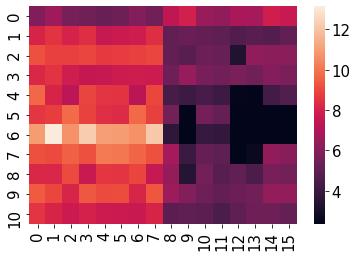

In [88]:
# uniform_data2 = (uniform_data>0.5)+(uniform_data<-0.5)*-1
uniform_data2 = x_train[:,np.union1d(idx[0],idx[1])].T
sns.heatmap(uniform_data2)

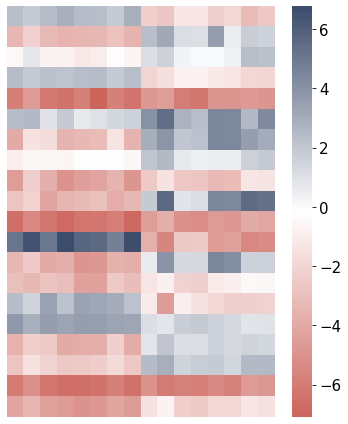

In [181]:
plt.figure(figsize= (5,6))
sub = x_train[:,[89,0,0,472,0,0,0,0,0,0,0,929,0,0,1008,12,0,0,0,0]] - x_train[:,[0,200,11,0,13,14,742,20,19,889,17,0,933,16,0,0,1020,1199,15,18]]
sns.heatmap(sub.T,xticklabels = False, yticklabels = False, cmap = custom_ramp)
plt.tight_layout()
plt.savefig('./workflow/heatmap2.svg',dpi=600)

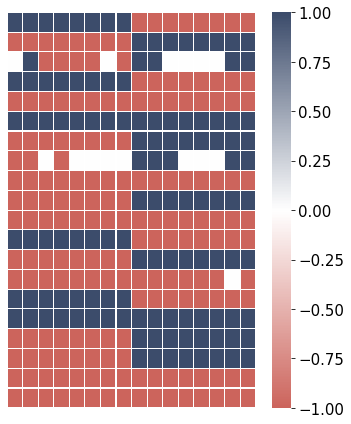

In [182]:
plt.figure(figsize= (5,6))
sub2 = (sub>0.5)*1 + (sub<-0.5)*-1
sns.heatmap(sub2.T,linewidths=.1,xticklabels = False, yticklabels = False, cmap = custom_ramp)
plt.tight_layout()
plt.savefig('./workflow/heatmap3.svg',dpi=600)

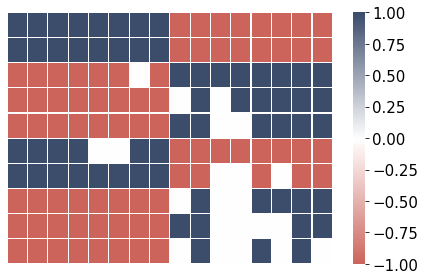

In [207]:
# plt.figure(figsize= (5,6))
sub = x_train[:,[1199,929,0,0,0,0,200,0,0,0]] - x_train[:,[  0,0 ,742, 1008,89, 889, 0,933,472,1020]]
sub2 = (sub>1.4)*1 + (sub<-1.4)*-1
sub2[:,5]=sub2[:,5][-1::-1]
sns.heatmap(sub2.T,linewidths=.1,xticklabels = False, yticklabels = False, cmap = custom_ramp)
plt.tight_layout()
plt.savefig('./workflow/heatmap4.svg',dpi=600)

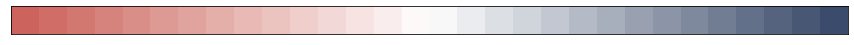

In [179]:
def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp( ['#cc645c','#ffffff','#3c4c6b' ] ) 

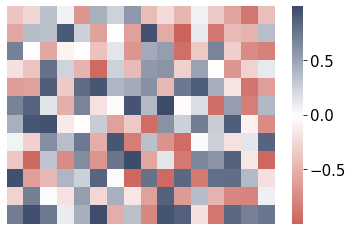

In [180]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

viridis = cm.get_cmap('viridis', 12)
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(90/256, 1, N)
vals[:, 1] = np.linspace(39/256, 1, N)
vals[:, 2] = np.linspace(41/256, 1, N)
newcmp = ListedColormap(vals)
ax = sns.heatmap(uniform_data,xticklabels = False, yticklabels = False, cmap = custom_ramp)